In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


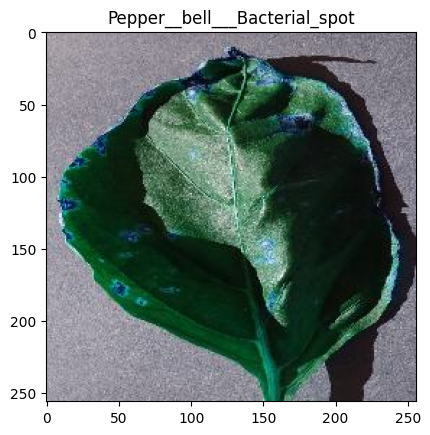

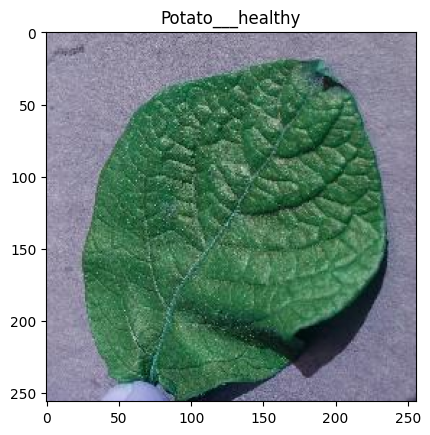

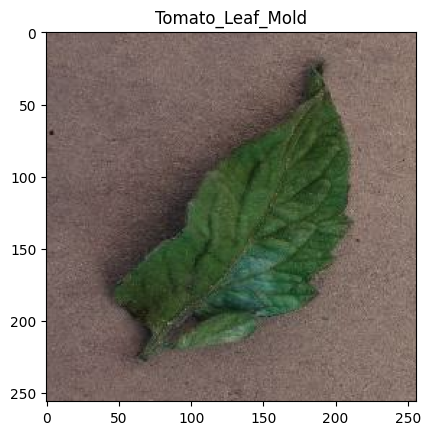

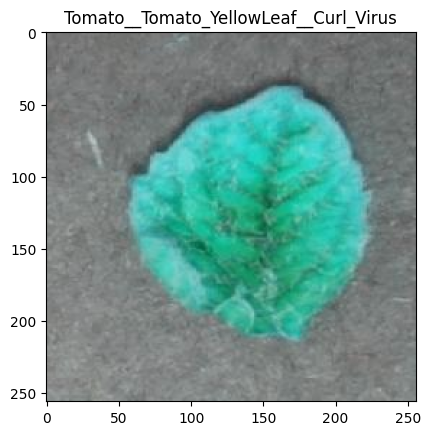

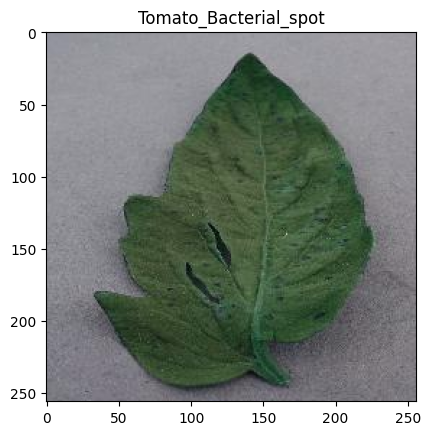

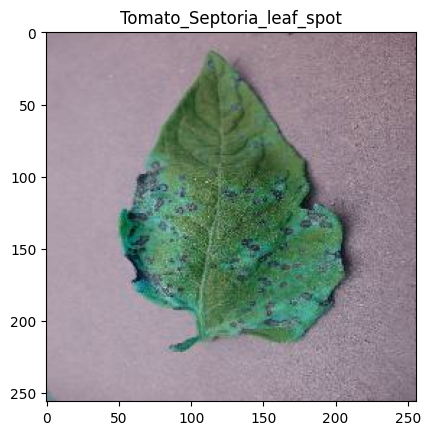

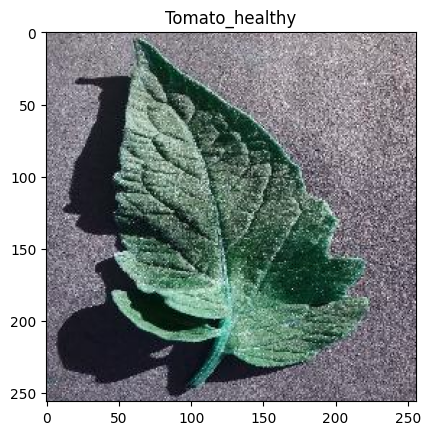

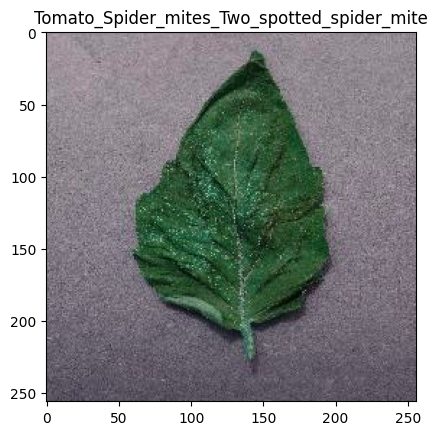

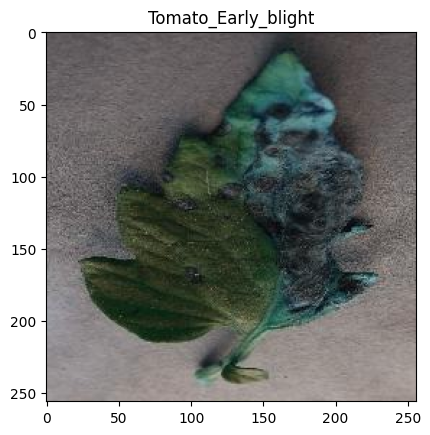

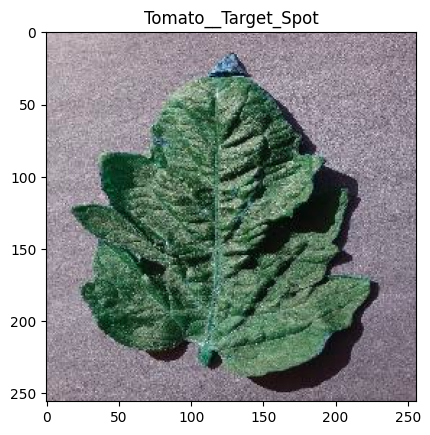

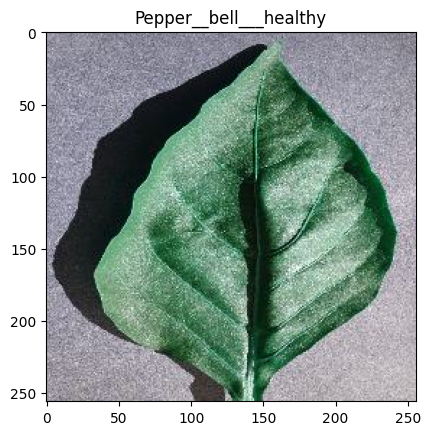

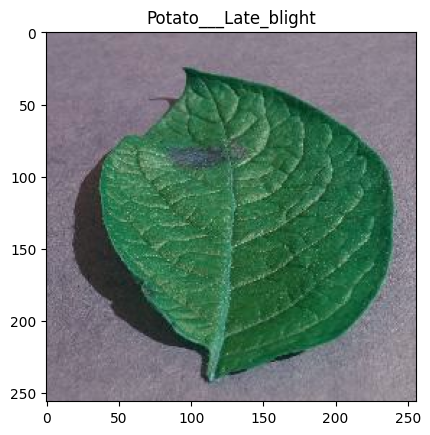

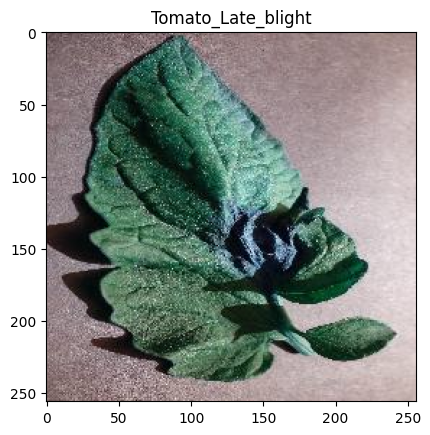

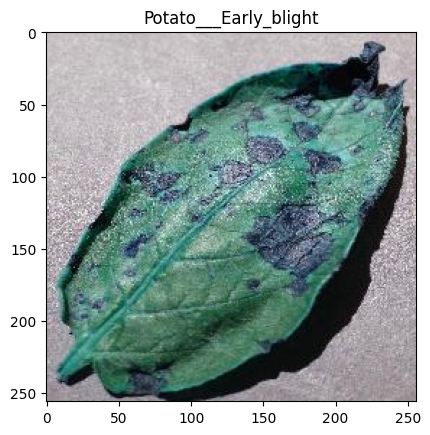

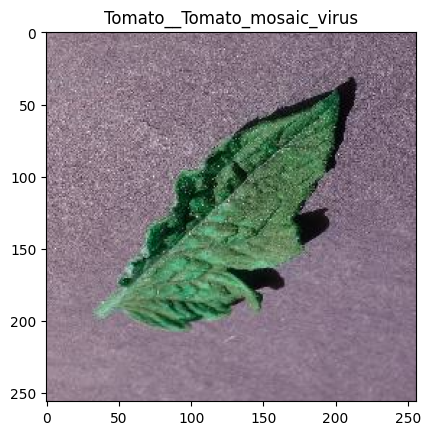

In [2]:
DATA_PATH = '../input/plantdisease/PlantVillage'

for cat in os.listdir(DATA_PATH):
    path = os.path.join(DATA_PATH, cat)
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
        plt.imshow(image)
        plt.title(f'{cat}')
        plt.show()
        break

In [3]:
IMG_SHAPE = (224, 224)
INPUT_SHAPE = [224, 224, 3]
EPOCHS = 50
BS = 32
img_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, horizontal_flip=True, vertical_flip=True,
                                 shear_range=0.2, validation_split=0.25)

train_data_gen = img_data_gen.flow_from_directory(DATA_PATH, batch_size=BS, subset='training', 
                                                  class_mode='categorical', shuffle=True) 

val_data_gen = img_data_gen.flow_from_directory(DATA_PATH, batch_size=BS, subset='validation', 
                                                  class_mode='categorical', shuffle=True)

Found 15482 images belonging to 15 classes.
Found 5156 images belonging to 15 classes.


In [4]:
label = train_data_gen.class_indices
label

{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

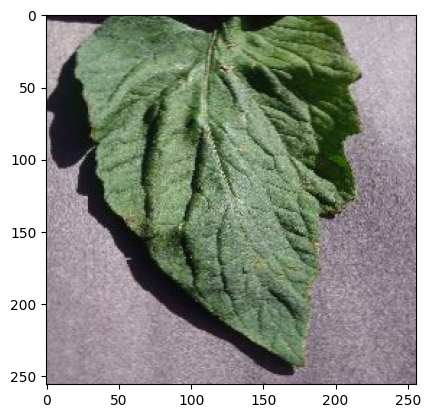

In [5]:
img = train_data_gen.__getitem__(11)[0]
plt.imshow(img[0])
#plt.title(label[11])

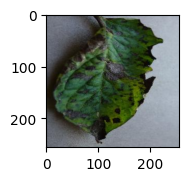

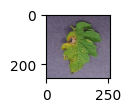

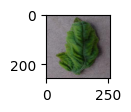

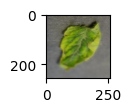

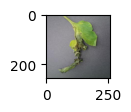

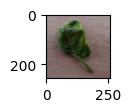

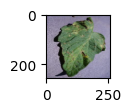

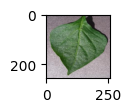

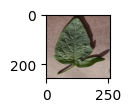

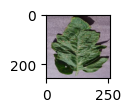

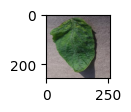

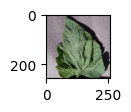

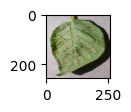

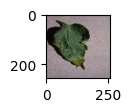

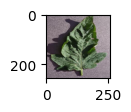

In [6]:
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(5, 3, i+1)
    img = train_data_gen.__getitem__(i)[0]
    plt.imshow(img[0])
    plt.xticks()
    plt.show()

In [7]:
def model_building(model_name, INPUT_SHAPE=INPUT_SHAPE):
    print('Model Initialization started')
    base_model = model_name(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    
    for layers in base_model.layers:
        layers.trainable = False
    print('Model Initialization finished')
    
    #model creation
    print('Model creation started')
    inp_model = base_model.output
    
    x = GlobalAveragePooling2D()(inp_model)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(15, activation = 'sigmoid')(x)
    
    model = Model(inputs = base_model.input, outputs = x)
    
    #model summary
    print('Model summary')
    #model.summary()
    
    #model compilation
    model.compile(optimizer = 'adam', metrics=['accuracy'], loss = 'categorical_crossentropy')
    
    history = model.fit(train_data_gen, validation_data=val_data_gen, 
                       validation_steps=len(val_data_gen)//BS,
                       steps_per_epoch=len(train_data_gen)//BS,
                       batch_size=BS, 
                       epochs=EPOCHS)
    
    print('Model Building Finished')
    
    !mkdir -p saved_model
    model.save(f'saved_model/{model_name}_1.h5')
    print('Model was saved')
    
    return history

In [8]:
def evaluation_plot(model):
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(10, 8))
    plt.plot(model['loss'], label = 'loss')
    plt.plot(model['accuracy'], label = 'accuracy')
    plt.plot(model['val_loss'], label = 'val_loss')
    plt.plot(model['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.title('Model Evaluation')
    plt.show()

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

In [10]:
vgg16_hist = model_building(VGG16)

Model Initialization started
58889256/58889256 [==============================] - 2s 0us/step
Model Initialization finished
Model creation started
Model summary
Epoch 1/50
15/15 [==============================] - 22s 850ms/step - loss: 2.6290 - accuracy: 0.1458 - val_loss: 2.5223 - val_accuracy: 0.1437
Epoch 2/50
15/15 [==============================] - 13s 876ms/step - loss: 2.4661 - accuracy: 0.2125 - val_loss: 2.3931 - val_accuracy: 0.2688
Epoch 3/50
15/15 [==============================] - 13s 867ms/step - loss: 2.3353 - accuracy: 0.2333 - val_loss: 2.2611 - val_accuracy: 0.2812
Epoch 4/50
15/15 [==============================] - 13s 857ms/step - loss: 2.3117 - accuracy: 0.2625 - val_loss: 2.1531 - val_accuracy: 0.4250
Epoch 5/50
15/15 [==============================] - 12s 820ms/step - loss: 2.1882 - accuracy: 0.3479 - val_loss: 2.1070 - val_accuracy: 0.3125
Epoch 6/50
15/15 [==============================] - 12s 837ms/step - loss: 2.1064 - accuracy: 0.3250 - val_loss: 2.0073 - va

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


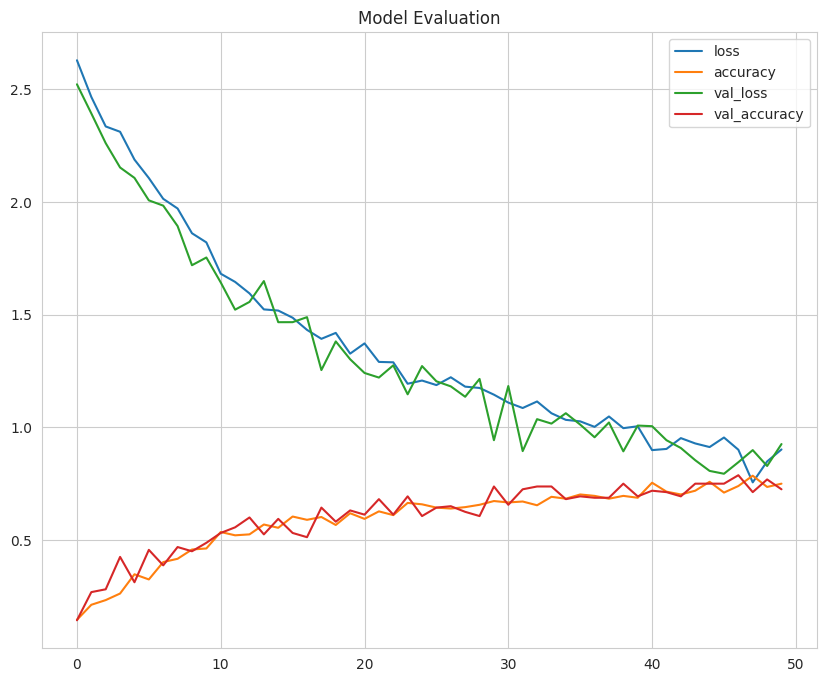

In [11]:
evaluation_plot(vgg16_hist.history)

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [13]:
inc_history = model_building(InceptionV3)

Model Initialization started
87910968/87910968 [==============================] - 3s 0us/step
Model Initialization finished
Model creation started
Model summary
Epoch 1/50
15/15 [==============================] - 17s 752ms/step - loss: 2.3584 - accuracy: 0.2625 - val_loss: 1.9001 - val_accuracy: 0.4437
Epoch 2/50
15/15 [==============================] - 10s 672ms/step - loss: 1.6829 - accuracy: 0.5042 - val_loss: 1.4593 - val_accuracy: 0.5125
Epoch 3/50
15/15 [==============================] - 10s 662ms/step - loss: 1.4239 - accuracy: 0.5479 - val_loss: 1.1692 - val_accuracy: 0.5938
Epoch 4/50
15/15 [==============================] - 10s 650ms/step - loss: 1.2074 - accuracy: 0.6146 - val_loss: 1.0748 - val_accuracy: 0.7000
Epoch 5/50
15/15 [==============================] - 10s 662ms/step - loss: 1.1196 - accuracy: 0.6438 - val_loss: 1.1275 - val_accuracy: 0.6562
Epoch 6/50
15/15 [==============================] - 10s 660ms/step - loss: 1.0775 - accuracy: 0.6625 - val_loss: 1.0963 - va

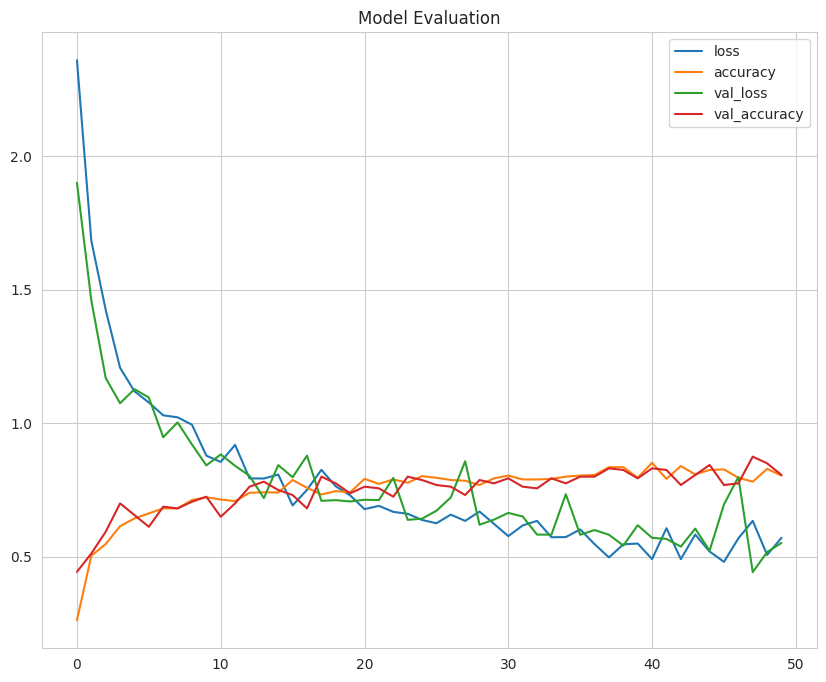

In [14]:
evaluation_plot(inc_history.history)